In [1]:
from LABNET import Neuron, Net, Lab, Teacher,compare_rows

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from collections import OrderedDict

In [3]:
def perturb_weights(model, perturbation_amount):
    for layer in model.layers:
        if hasattr(layer, 'kernel'):
            weights = layer.get_weights()
            perturbations = [np.random.uniform(-perturbation_amount, perturbation_amount, w.shape) for w in weights]
            perturbed_weights = [w + perturbation for w, perturbation in zip(weights, perturbations)]
            layer.set_weights(perturbed_weights)

# Example usage:
# Save the perturbed weights
#perturbation_amount = 0.1
#perturb_weights(model, perturbation_amount)
#save_weights(model, 'perturbed_model_weights.h5')


## Adding a few hyperparameters ##

first, instead of storing gradients we store standard deviations.  we will need a default to start.  
then there is kappa.  this may move as we go lower, or whatever, but kappa is the number of samples.  
then there is a percentage of neurons to sample at each kappa iteration.  min value here should be only one neuron, and the max should be all.  this could be randomly determined maybe?.  
so, lets say you are doing the min, one neuron per kappa iteration.  
you look up that neurons standard deviation (which i think i use gradients instead)
and you sample using the standard deviation for that neuron, and the weight value as the mean.  get kappa losses that each correspond to a sampled weight.  you have kappa loss weight pairs for that neuron.  pick the lowest loss, set the weight to that sampled value, and set the standard deviation to whatever that selected weight is from the previous one.  so, if the sampled value is outside the 1 sd bound, it is going to search a wider area, if it is less, it will search a smaller one.  if it doesn't sample one that is better than the current value, it gets multiplied by some fixed number greater than 1.  so, to get to the GLOBAL minima, those values all go big, and it can search over huge areas and won't find anything smaller.  so you could see how often it selects a better value, that should reduce as more iterations happen.  



![Alt text](normal.png)

theory i guess:gradient explosion or collapse is a spectrum.  first, is it normally distributed? i think its distribution is a function of the architecture, the depth and the number of neurons.  depth contribution makes the most sense.  you need all the deep layers to compound to get either issue.  as you get deeper, the risk of catastrophic gradient deviation increases, or, if we think about training lots of neural networks, or just the same neural network multiple times, it likely does that in some distribution.  so, we should either see the earliest layers train first if the gradient explodes, or the latter layers to train first (if vanish or collapse).   however, it looks like it does one or the other and runs into a minima. a decent minima even.  what would that mean.  it means on the loss landscape there may be lots of really decent places for the weights to end up, even if it doesn't match the ideal (controlled generated) weights.  
WHAT IF SOME INDIVIDUAL VALUES INSIDE WEIGHT MATRICES (i need a name for not a neuron, but an individual weight inside that tensor)

so, look at lots of em, see if there is evidence for that.  

then, is there a way to cut the compounding during the backward pass.  what if each layer only takes into account the next weight layer, doesnt' back propagate all the way back.  does that make it so each neuron can pull its weight?

In [4]:
def plot_line_graph(numbers
                    ,window_size = 1
                    ,plot_size = (10,6)
                    ,x_range = (None, None)
                    ,y_range = (None, None)
                   ):
    
    if window_size <= 0 or window_size > len(numbers):
        raise ValueError("Invalid window size")
    
    running_sum = sum(numbers[:window_size])
    averages = [running_sum / window_size]

    for i in range(window_size, len(numbers)):
        running_sum += numbers[i] - numbers[i - window_size]
        averages.append(running_sum / window_size)
    
    
    
    x = range(1, len(averages) + 1)  
    y = averages  # y-axis values
    plt.figure(figsize=plot_size)
    plt.plot(x, y)  # Plotting the line graph
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    if x_range[0] is not None and x_range[1] is not None:
        plt.xlim(x_range[0], x_range[1])
    if y_range[0] is not None and y_range[1] is not None:
        plt.ylim(y_range[0], y_range[1])
    
    plt.title('loss')

    plt.show() 

In [5]:
import torch


In [41]:


n = 1000 #number of samples to generate
layer_sizes = [8, 7,7,4]  # Inputs: 4, Hidden layers: [8, 8], Outputs: 3
neural_network = Teacher(layer_sizes)
#initialize_weights_uniform(neural_network,0,1)


In [42]:
neural_network.generate_data(
    n
    ,'normal'
    , m =0.0
    , std=1.0
    , gen_lr = 0.01
    , gen_epochs = 1000
)

In [8]:
# make this a function of the Teacher obj, i think save all the generate settings then just pass number of samples


In [58]:
neural_network.model(neural_network.inputs[105])

tensor([ 1.1047e-01, -2.3311e-01,  1.0710e-04,  1.9248e-02],
       grad_fn=<AddBackward0>)

In [44]:
neural_network.model.state_dict()
#torch.save(neural_network.model.state_dict(), 'model_weights.pth')

OrderedDict([('input_layer.weight',
              tensor([[ 0.1508, -0.1135, -0.1432,  0.6610,  0.1565, -0.0913, -0.2193,  0.4682],
                      [ 0.5761, -0.4855, -1.0136, -0.0774, -0.1251, -0.5172, -0.1477, -0.7144],
                      [-0.5067, -0.2027,  0.3655,  0.3895,  0.6768,  0.2515,  0.3108, -0.8019],
                      [ 0.6008, -0.2331,  0.5321, -0.7033, -0.0241,  0.4976,  0.5779, -0.3113],
                      [ 0.3107,  0.8202, -0.7820, -0.8355, -0.5627, -0.8002, -0.7004, -0.9135],
                      [-0.7524,  0.8920, -0.4225,  0.7553,  0.2946, -0.2965, -0.2065,  0.2268],
                      [ 0.2017, -0.2931, -0.7654,  0.1668, -0.4529, -0.3418,  0.3572, -0.6305]])),
             ('input_layer.bias',
              tensor([ 0.1994,  1.1154,  0.2177,  0.4131,  0.6990,  0.2615, -0.1089])),
             ('hidden_layer_2.weight',
              tensor([[ 0.5664, -0.9186, -0.7345,  0.3514, -0.4712, -0.1748,  0.7111],
                      [ 0.5917, -0.5350, 

In [96]:
# Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = nn.Linear(8, 7) ##make these all variables duh
        self.hidden_2 = nn.Linear(7,7)
        #self.hidden_3 = nn.Linear(7,7)
        #self.hidden_4 = nn.Linear(7,7)
        #self.hidden_5 = nn.Linear(7,7)
        self.output = nn.Linear(7, 4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden_1(x))
        x = self.relu(self.hidden_2(x))
        #x = self.relu(self.hidden_3(x))
        #x = self.relu(self.hidden_4(x))
        #x = self.relu(self.hidden_5(x))
        x = self.output(x)
        return x

In [97]:
mymodel = MyModel()
print(mymodel)

MyModel(
  (hidden_1): Linear(in_features=8, out_features=7, bias=True)
  (hidden_2): Linear(in_features=7, out_features=7, bias=True)
  (output): Linear(in_features=7, out_features=4, bias=True)
  (relu): ReLU()
)


In [98]:
def rename_state_dict_keys_by_order(model, reference_model):
    model_keys = list(model.state_dict().keys())
    reference_keys = list(reference_model.state_dict().keys())
    name_mapping = dict(zip(model_keys, reference_keys))
    
    new_state_dict = OrderedDict()
    for key in model.state_dict():
        new_key = name_mapping[key]
        new_state_dict[new_key] = model.state_dict()[key]
    return new_state_dict

def perturb_weights(model, std_dev):
    for param in model.parameters():
        noise = np.random.normal(loc=0.0, scale=std_dev, size=param.data.shape)
        param.data.add_(torch.from_numpy(noise))
        
def scale_weights(model, scaling_factor):
    for param in model.parameters():
        param.data.mul_(scaling_factor)
        
def calculate_validation_loss(model, validation_inputs, validation_outputs, loss_function):

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for validation
        #validation_inputs = validation_inputs.to(device)  # Move inputs to the appropriate device (e.g., GPU)
        #validation_outputs = validation_outputs.to(device)  # Move targets to the appropriate device

        # Forward pass
        outputs = model(validation_inputs)

        # Compute the loss
        loss = loss_function(outputs, validation_outputs)

        # Calculate the loss
        average_loss = loss.item()

    model.train()  # Set the model back to training mode

    return average_loss

def val_histogram(data_list, bins=10, title="val_hist", xlabel="Values", ylabel="Frequency"):

    plt.hist(data_list, bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [15]:
#####ONLY RUN THIS TO LOAD WEIGHTS

load_this = rename_state_dict_keys_by_order( neural_network.model,mymodel)

mymodel.load_state_dict(load_this)
#mymodel.state_dict()


<All keys matched successfully>

In [99]:
##STARTING with the right answuers gives some close to zero row_comp:3.5974587e-08,0.0,0.0; 0.0,2.9802322e-08,1.4901161e-08
#interesting that you get a zero, and then a close to zero.  
#perturb_weights(mymodel, std_dev = 0.005) # converges
#perturb_weights(mymodel, std_dev = 0.009) # converges
#perturb_weights(mymodel, std_dev = 0.05) doesn't converge
#perturb_weights(mymodel, std_dev = 0.01) #converges
#perturb_weights(mymodel, std_dev = 0.01) #not converging well, even with lower lr, 0.003. 1t 0.001


# scale_weights(mymodel, scaling_factor = 1.1) ## converges, weights cross.  
#scale_weights(mymodel, scaling_factor = 1.5) ## good validation, non zero row comapre still..

#scale_weights(mymodel, scaling_factor = 2) ## good validation, row compare stays pretty close to the same...
## scale_weights(mymodel, scaling_factor = 1.05) row compare barely improves!!
mymodel.state_dict()

OrderedDict([('hidden_1.weight',
              tensor([[-0.2372, -0.0914,  0.1935, -0.3432, -0.2159,  0.2277, -0.2355,  0.1363],
                      [ 0.1549,  0.2813, -0.0791,  0.0061, -0.2875, -0.2863, -0.1901,  0.3107],
                      [ 0.1909, -0.3103,  0.1030, -0.2097, -0.0712, -0.0176, -0.2373,  0.0283],
                      [-0.3207, -0.3075,  0.0960,  0.1501,  0.0615,  0.3354, -0.3212, -0.0152],
                      [ 0.2588,  0.2672,  0.2238,  0.2251,  0.2691, -0.0632, -0.2691,  0.1832],
                      [ 0.2219,  0.1948, -0.2298, -0.1654, -0.1760,  0.0719,  0.1804, -0.1099],
                      [-0.2153,  0.2785, -0.1795,  0.3259,  0.2192,  0.2119, -0.0129, -0.0355]])),
             ('hidden_1.bias',
              tensor([ 0.0751,  0.2319, -0.0734, -0.2621, -0.0353, -0.1704,  0.3222])),
             ('hidden_2.weight',
              tensor([[-0.2291,  0.2632, -0.0886, -0.1226, -0.2334,  0.0982, -0.0255],
                      [-0.1466,  0.3280, -0.1243, -0.

In [100]:
test_list = list(zip([row for row in neural_network.model.parameters() if len(row.shape) > 1],
                     [row for row in mymodel.parameters() if len(row.shape) > 1]))

for i in test_list:
    #this first line will print out the row similarity matrix.
    #print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[0])
    print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[1])

8.770845
7.237585
4.3780627


OKAY.  to do.  first, go through this and annotate it really well.  From how the graphs look (especially on low epochs) it is doing what i expect: it searches over kappa weights, and picks the best.  

looking at higher epochs, it very infrequently stays the same. Convergence I imaging would have lots of the weights being at the best values, but that doesn't seem to be happening.  in fact, it gets way unstable.  

as it is, kappa is just how many times it rolls the dice and sets the weight.  that still leaves the training data input way up to chance.  I think i need a lambda as well:
    1. pick a neuron.  
        a. roll the dice (do this kappa times).  use the standard deviation (stored in the gradient) to sample the weight
            i. now, get lambda input samples.  (batches i think?), and we get the average loss? best loss? and that is that weights score.  this is the new bit.

In [101]:
import torch
import torch.optim as optim

#these are just for debugging purposes. 
kappa_global = [] #this stores the kappas for each randomly selected neuron.
min_global = [] #this stored the minimum of the kappas, 
std_global = [] #stores the set st. deviations.

class CustomStochasticOptimizer(optim.Optimizer):
    def __init__(self, params, kappa, std_init=1):
        super(CustomStochasticOptimizer, self).__init__(params, {})
        self.kappa = kappa
        self.kappa_iter = kappa #this works with the way the code is written in step.
        self.param_shapes = [p.data.shape for group in self.param_groups for p in group['params']]
        #print(self.param_shapes)
        self.param_idx = None
        self.neuron_idx = [] ##this dim will change, biases have one, matrices 2, bla bla
        self.current_std = 1.0
        self.current_mean = 0.0
        self.current_loss = 0.0
        self.kappa_memory = [] #will hold tuples, kappa quantity
        # Set the gradients for all model parameters to std_init
        for group in self.param_groups:
            for p in group['params']:
                p.grad = torch.zeros_like(p.data) + std_init
                #print(p.grad)

    def get_nested_data(self, data, indices):
        def _get_nested_data(self,data, indices):
            if len(indices) == 1:
                return data[indices[0]]
            else:
                next_index = indices[0]
                remaining_indices = indices[1:]
                next_data = data[next_index]
                return _get_nested_data(self,next_data, remaining_indices)
    
        return _get_nested_data(self,data, indices)
    
    #def i need a set function similar to get_nested_data that takes param index, neuron idx, and sets the weight and the std
    ## might be a good idea to calculate the new std as well.
    ##future: hyper parameters to indicate like, a max and min std?
    #change kappa based on the value of the std??
    ##thats interesting.  if the std gets bigger we sample more? its less sure of being in a good place of LL so look more for that neuron?
    
    def step(self, closure=None):
        
        if self.kappa_iter < self.kappa:  
            #runs while kappa isn't full
            self.kappa_iter += 1
            param_group = self.param_groups
            """now it skips to the section below marked ***"""
            
        else: #self.kappa_iter == self.kappa
            
            #assert(self.kappa_iter == self.kappa)
            
            ##set the previous stuff here before resampling.  
            
            if len(self.kappa_memory) > 0: ##this is just to skip the initial case.
                
                """
                This runs when kappa is full.  notice the *_global appends.  
                """
                
                kappa_global.append(self.kappa_memory)
                
                #min_tuple = min(self.kappa_memory, key=lambda x: x[1])
                min_index, min_value = min(enumerate(self.kappa_memory), key=lambda x: x[1][1])
                #print(min_index,min_value, min_tuple[0])
                new_weight = min_value[0]
                
                new_std = 0
                if min_index == 0:
                    """
                    This means that the best weight was the original weight, up the std
                    """
                    new_std = self.current_std * 2 #this could be a hyper param.  
                else:
                    """
                    There was a better weight, look over a smaller window next time.
                    """
                    new_std = abs(new_weight - self.current_mean) 
                    ##just for me, we are setting it here, but we won't use the set value until we select this neuron
                    ##later. always read the std from the gradient.  that is done below
                min_global.append(new_weight)
                
                
                #also, add a lower bound, and an upper bound?
                ##beside min_tuple, if it is the same one, increase the std?
                
                if len(self.neuron_idx) == 1: #this just means it is a bias layer, so the tensor is only 1 d
                    self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]] = new_weight
                    self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]] = new_std
                else: #this is a 2d layer.
                    self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]][self.neuron_idx[1]] = new_weight
                    self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]][self.neuron_idx[1]] = new_std
                
                
            
            self.kappa_memory = [] 
            self.kappa_iter = 1
            
            ######This is where we roll the dice for a new std.
            self.param_idx = random.randint(0,len(self.param_shapes)-1)
            this_param_shape = self.param_shapes[self.param_idx]
            self.neuron_idx = [random.randint(1,i)-1 for i in this_param_shape]
            
            #get the std from the grad slot
            if len(self.neuron_idx) == 1:
                #self.param_groups[0]['params'][self.param_idx].grad = torch.zeros_like(self.param_groups[0]['params'][self.param_idx].grad) + 3
                self.current_std = self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]]
                
            else:
                self.current_std = self.param_groups[0]['params'][self.param_idx].grad[self.neuron_idx[0]][self.neuron_idx[1]]
                
            
            
            ######store the values before you sample....
            self.current_mean = self.get_nested_data(self.param_groups[0]['params'][self.param_idx], self.neuron_idx)
            
            if closure is not None:
                self.current_loss = closure
            
            
            
            self.kappa_memory.append((float(self.current_mean),float(self.current_loss))) 
            
            ##read the std to use for sampling here
            self.current_std = self.get_nested_data(self.param_groups[0]['params'][self.param_idx].grad, self.neuron_idx)
            std_global.append(self.current_std)
            
            
        """*** Resumes here from the if above
        This runs every iteration of kappa.  
        """  
        first_weight = self.kappa_memory[0][0] #the weight when we selected this neuron is stored in [0][0]. use it to sample
        test_weight = torch.normal(mean=float(first_weight), std=float(self.current_std), size=(1,)) 
        #print(self.current_std, self.kappa_iter) #std isn't being set!!
        if len(self.neuron_idx) == 1:
            self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]] = test_weight
        else:
            self.param_groups[0]['params'][self.param_idx][self.neuron_idx[0]][self.neuron_idx[1]] = test_weight
        
        #print(self.current_mean, self.current_std, self.param_idx,self.neuron_idx, test_weight)
        
        loss = None
        if closure is not None:
            loss = closure
        #print(loss)
        self.kappa_memory.append((float(test_weight),float(loss))) 
       
        return loss

In [102]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(mymodel.parameters(), lr=0.001) #decay schedule??
optimizer = CustomStochasticOptimizer(mymodel.parameters(),kappa=10)

In [103]:
input_data = neural_network.inputs
output_data = neural_network.targets

In [104]:
for param in mymodel.parameters():
        param.detach_()

In [105]:
# Training loop
#samples = n
samples = input_data.shape[0]
#print(samples)
num_epochs = 200

lab = Lab(mymodel,num_epochs,samples)
data = list(zip(input_data, output_data))

losses = []

for epoch in range(num_epochs):
    
    sample = 0
    
    random.shuffle(data)
    shuffled_inputs, shuffled_outputs = zip(*data)
    
    #optimizer.zero_grad()
    for inputs, targets in zip(shuffled_inputs, shuffled_outputs):
        
        inputs = inputs.unsqueeze(0)  
        targets = targets.unsqueeze(0)
    
        output = mymodel(inputs)
        
        loss = criterion(output, targets)
        
        #optimizer.zero_grad()
        #loss.backward()
        
        optimizer.step(loss)
        lab.record(mymodel,epoch,samples,sample)
        #print or store loss if you wanna
        losses.append(loss.item())

        
        sample += 1
 


72.02639
35.46154
14.608459
_______


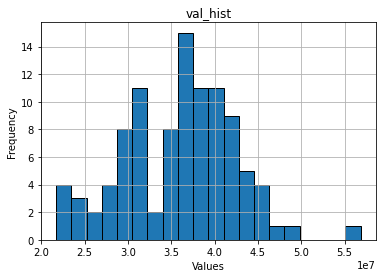

In [106]:
#this will only work if the networks have the same architecture
test_list = list(zip([row for row in neural_network.model.parameters() if len(row.shape) > 1],
                     [row for row in mymodel.parameters() if len(row.shape) > 1]))

for i in test_list:
    #this first line will print out the row similarity matrix.
    #print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[0])
    print(compare_rows(i[0].detach().numpy(),i[1].detach().numpy())[1])
print('_______')  
# VALIDATION
iterations = 100
val_samples = 100
m = 0.0
std = 1.0

val_list = []
for _ in range(iterations):
    val_inputs = torch.from_numpy(np.random.normal(m, std, (val_samples,layer_sizes[0])).astype(np.float32))
    val_outputs = neural_network.model(val_inputs)
    this_val_acc = calculate_validation_loss(mymodel, val_inputs, val_outputs, criterion)
    val_list.append(this_val_acc)
    
val_histogram(val_list, bins=20, title="val_hist", xlabel="Values", ylabel="Frequency")

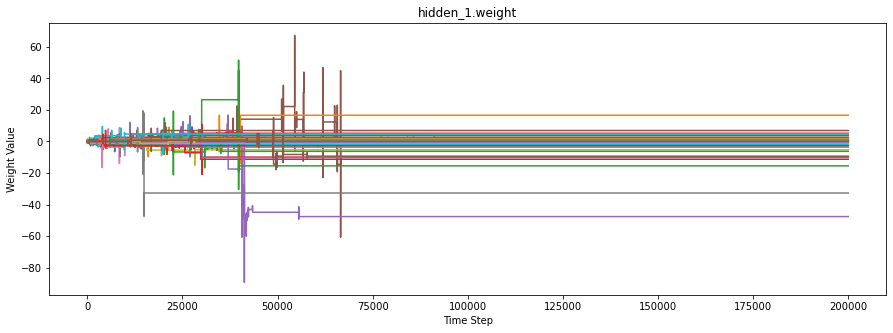

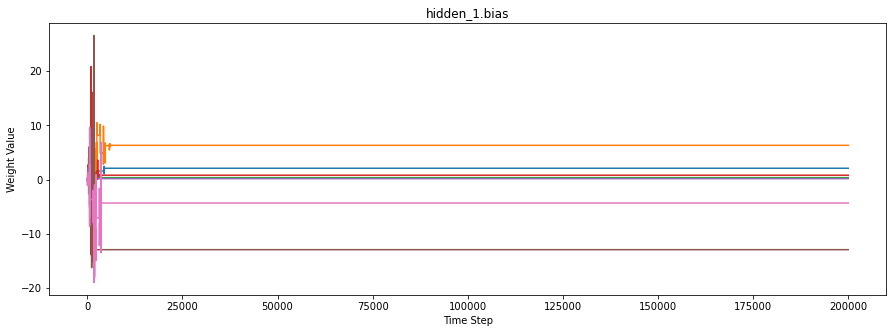

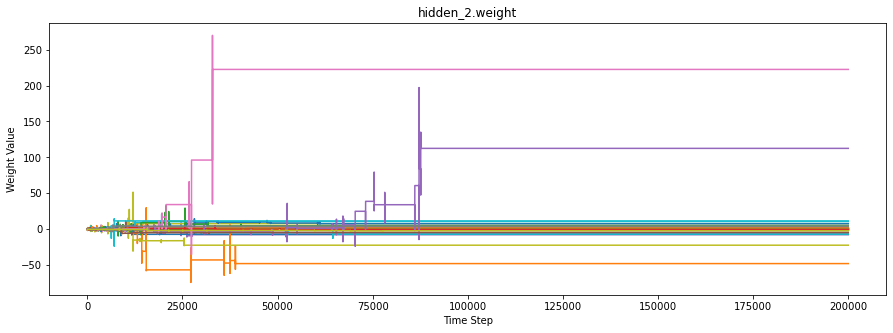

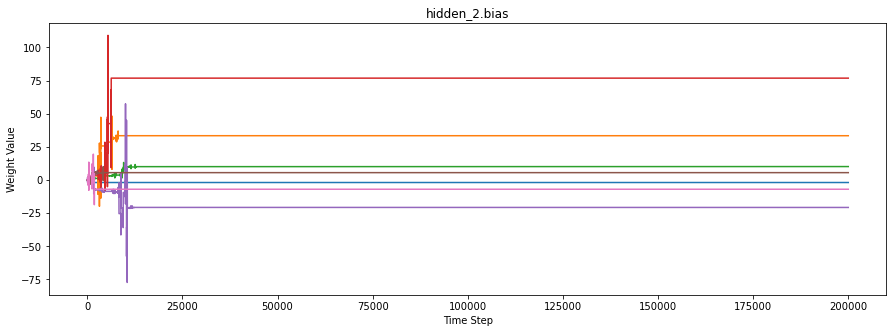

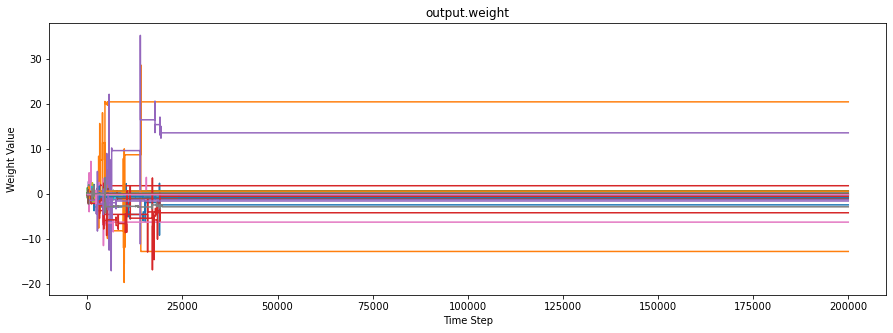

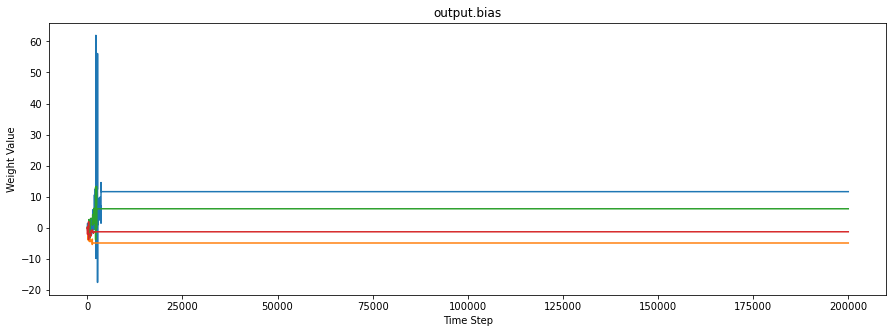

In [107]:
##x_range = (99998,100000) to view final weights
lab.graph(diff=0,graph_together = False, plot_size = (15,5) )

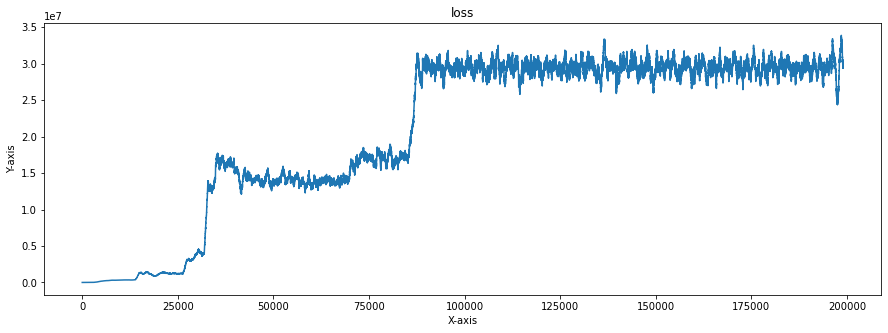

In [108]:
plot_line_graph(losses,window_size = 1000, plot_size = (15,5)) #window_size is the moving average window

In [109]:
kappa_global[0]

[(-0.06321892142295837, 0.023796308785676956),
 (-0.26564136147499084, 0.023796308785676956),
 (-0.4011499881744385, 0.02542816661298275),
 (1.224793791770935, 0.07073163986206055),
 (1.5152498483657837, 0.051000647246837616),
 (-1.2893394231796265, 0.04279947653412819),
 (1.0530927181243896, 0.05976642295718193),
 (0.5728740692138672, 0.08956434577703476),
 (0.8315606117248535, 0.0246584452688694),
 (-1.2676045894622803, 0.03802803158760071),
 (-0.5696162581443787, 0.004973433446139097)]

In [111]:
min_global

[-0.5696162581443787,
 1.2060378789901733,
 0.6232196688652039,
 1.1788631677627563,
 -0.09847810864448547,
 -0.18218058347702026,
 -0.4040030241012573,
 1.268844485282898,
 -1.1346081495285034,
 2.670788526535034,
 -0.8931018114089966,
 -0.46066585183143616,
 -0.08917021751403809,
 0.06368521600961685,
 1.2230695486068726,
 0.09086726605892181,
 -1.0909805297851562,
 -1.1499711275100708,
 1.0802030563354492,
 -0.4350329041481018,
 -1.5547595024108887,
 -3.5851781368255615,
 -0.3497825562953949,
 -1.449154019355774,
 0.0063457125797867775,
 0.15813443064689636,
 -0.46066585183143616,
 -1.7692317962646484,
 0.10934903472661972,
 -1.2973592281341553,
 0.07022900134325027,
 0.41124892234802246,
 -2.007591485977173,
 1.1550981998443604,
 0.8913100361824036,
 0.5872675776481628,
 0.9158034324645996,
 3.329552173614502,
 0.37407782673835754,
 -0.4026009142398834,
 0.23996159434318542,
 0.8913100361824036,
 1.1206859350204468,
 0.17156755924224854,
 -3.861328601837158,
 -0.0392947793006897,
 